# **Task 2 - Deep Learning Model Development**

### Import Libraries

In [1]:
import numpy as np
import pandas as pd
import torch 
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision  
import torchvision.transforms as transforms  
from torchvision import datasets, models
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
import os

### GPU Support

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


### Load and Process Multiple Images

In [3]:
image_folder = "blood_cell_images/"

In [4]:
image_files = [f for f in os.listdir(image_folder) if f.endswith(('.png', '.jpg', '.jpeg'))]

### Define transformations

In [5]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(), 
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  
])

### Load dataset

In [6]:
dataset = ImageFolder(root=image_folder, transform=transform)

### Create DataLoader

In [7]:
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [8]:
print("Classes:", dataset.classes)

Classes: ['class_0', 'class_1']


In [9]:
images, labels = next(iter(dataloader))

###  Convert images to numpy format for visualization

In [10]:
def imshow(img):
    img = img / 2 + 0.5  
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

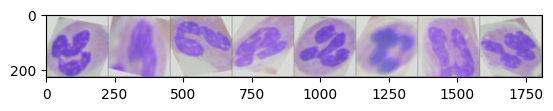

In [11]:
imshow(torchvision.utils.make_grid(images[:8]))

In [12]:
dataset_path = "blood_cell_images/"
train_dataset = datasets.ImageFolder(root=dataset_path, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

### Define CNN Model

In [13]:
class BloodCellCNN(nn.Module):
    def __init__(self):
        super(BloodCellCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * 56 * 56, 128)
        self.fc2 = nn.Linear(128, 2) 
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.softmax(self.fc2(x))
        return x

### Initialize Model

In [14]:
model = BloodCellCNN()
print(model)

BloodCellCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=200704, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
  (softmax): Softmax(dim=1)
)


### Train the Model

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

BloodCellCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=200704, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
  (softmax): Softmax(dim=1)
)

In [16]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [17]:
num_epochs = 10 

for epoch in range(num_epochs):
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

print("Training complete!")


Epoch [1/10], Loss: 0.7795
Epoch [2/10], Loss: 0.7820
Epoch [3/10], Loss: 0.7828
Epoch [4/10], Loss: 0.7810
Epoch [5/10], Loss: 0.7828
Epoch [6/10], Loss: 0.7816
Epoch [7/10], Loss: 0.7808
Epoch [8/10], Loss: 0.7834
Epoch [9/10], Loss: 0.7822
Epoch [10/10], Loss: 0.7824
Training complete!


###  Evaluate the Model

In [18]:
correct = 0
total = 0
model.eval()

with torch.no_grad():
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Model Accuracy: {accuracy:.2f}%")

Model Accuracy: 53.14%
